In [1]:
import numpy as np
from scipy import stats

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl    
mpl.rc('font',family='serif')

import seaborn as sns

import math
import time

from shapely.geometry import Point

import multiprocessing as mp

full_script_time = time.time()

In [2]:
def import_df():
    """Function for loading, handling and merging the data. Rigth now you don't use the prio gird thou.."""
    t1 = time.time()
    
    # load data:
    prio_grid = gpd.read_file("zip:///home/polichinel/Dropbox/KU/9.semester/friopgave/data/prio_grid/priogrid_cellshp.zip")
    prio_static = pd.read_csv("/home/polichinel/Dropbox/KU/9.semester/friopgave/data/prio_grid/static/PRIO-GRID Static Variables - 2018-08-21.csv")
    prio_yearly_interp = pd.read_csv("/home/polichinel/Dropbox/KU/9.semester/friopgave/data/prio_grid/yearly/PRIO_Yearly_interp.csv")
    prio_yearly = pd.read_csv("/home/polichinel/Dropbox/KU/9.semester/friopgave/data/prio_grid/yearly/PRIO-GRID Yearly Variables for 1946-2014 - 2018-08-21.csv")
    ucdp = pd.read_csv("/home/polichinel/Dropbox/KU/9.semester/friopgave/data/upsala/ged181.csv")# the error is not importent as you do not use that feature 
    
    ucdp =  ucdp[ucdp['gwnob'].isna()] # only conflicts NOT between to stats
    
    # Choosing ("most") relevant variables:
    prio_grid_lean = prio_grid[['gid','geometry']]
    prio_static_lean = prio_static[['gid','landarea','ttime_mean','mountains_mean','petroleum_s']]
    prio_yearly_interp_lean = prio_yearly_interp[['gid','year','interp_pop_gpw_sum','interp_gcp_ppp','interp_urban_ih','interp_agri_ih','interp_forest_ih']]
    prio_yearly_lean = prio_yearly[['gid','year','gwno','gwarea','bdist1','bdist3','capdist','excluded','petroleum_y','nlights_calib_mean']] #bdist 3 er minimere nans
    ucdp_lean = ucdp[['priogrid_gid','country_id','region','year','best']]

    
    # Choosing relevant years: 
    prio_yearly_interp_lean_1990 = prio_yearly_interp_lean[(prio_yearly_interp_lean['year'] >= 1990) & (prio_yearly_interp_lean['year'] <= 2010)] # men hvofor ikke 2015?
    prio_yearly_lean_1990 = prio_yearly_lean[(prio_yearly_lean['year'] >= 1990) & (prio_yearly_lean['year'] <= 2010)]
    ucdp_lean_1990 = ucdp_lean[(ucdp_lean['year'] >= 1990) & (ucdp_lean['year'] <= 2010)]
    
    # Aggregating yearly fatalities:
    ucdp_lean_1990_year_agg = ucdp_lean_1990.groupby(by=['priogrid_gid','country_id','year']).sum().reset_index() # det her virker.tror jeg
    ucdp_lean_1990_year_agg.rename(columns={'priogrid_gid':'gid'}, inplace=True)
    ucdp_lean_1990_year_agg.rename(columns={'country_id':'gwno'}, inplace=True)
    
    
    # Merging
    prio_yearly_lean_1990_all = pd.merge(prio_yearly_interp_lean_1990, prio_yearly_lean_1990, on = ['gid','year'])

    prio_static_grid = prio_grid_lean.merge(prio_static_lean, on='gid', how='inner')
    prio_sy_grid = prio_static_grid.merge(prio_yearly_lean_1990_all, on = 'gid', how='inner')
    prio_sy_ucdp_grid = prio_sy_grid.merge(ucdp_lean_1990_year_agg, on = ['gid','year','gwno'], how='left')

    
    # Filling in cells with non-fatalities.
    prio_sy_ucdp_grid['best'].fillna(value=0, inplace = True)
    prio_sy_ucdp_grid['log_best'] = np.log(prio_sy_ucdp_grid['best']+1)
    
    # Managing petolium:
    prio_sy_ucdp_grid['petroleum_y'] = prio_sy_ucdp_grid.sort_values('year').groupby('gid')['petroleum_y'].fillna(method = 'ffill').copy() # fint
    prio_sy_ucdp_grid['petroleum_y'].fillna(0, inplace = True)
    prio_sy_ucdp_grid['petroleum_s'].fillna(0, inplace = True)
    
    prio_sy_ucdp_grid['petroleum_full'] = np.maximum(prio_sy_ucdp_grid['petroleum_y'],prio_sy_ucdp_grid['petroleum_s'])
    
    prio_sy_ucdp_grid.drop('petroleum_y', axis=1, inplace=True)
    prio_sy_ucdp_grid.drop('petroleum_s', axis=1, inplace=True)
                                                        
    # Managing bdist1 
    #prio_sy_ucdp_grid['bdist1'].fillna(np.median(prio_sy_ucdp_grid['bdist1']), inplace = True) # kunne være fedt bare at ordne det i modellen.
    
    df_done = prio_sy_ucdp_grid[prio_sy_ucdp_grid['gwno'].notna()] # removes 12 fucks.
    
    print('seconds it took load and handle data: ' + str(time.time()-t1))
    return(df_done) # ucdp for dist. to conflict var.
    
    # Should you normelize the data... espec teh y 'best'

In [3]:
def import_df_point():
    
    t1 = time.time()
    ucdp = pd.read_csv("/home/polichinel/Dropbox/KU/9.semester/friopgave/data/upsala/ged181.csv")# the error is not importent as you do not use that feature 

    ucdp =  ucdp[ucdp['gwnob'].isna()] # only conflicts NOT between to stats

    ucdp_1990 = ucdp[(ucdp['year'] >= 1990) & (ucdp['year'] <= 2010)] #

    ucdp_1990_year_agg = ucdp_1990.groupby(by=['priogrid_gid','country_id','year', 'latitude', 'longitude']).sum().reset_index() # det her virker.tror jeg
    ucdp_1990_year_agg.rename(columns={'priogrid_gid':'gid'}, inplace=True)
    ucdp_1990_year_agg.rename(columns={'country_id':'gwno'}, inplace=True)

    ucdp_lean_1990_year_agg = ucdp_1990_year_agg[['gid','gwno','year','best']]

    ucdp_1990_year_agg['Coordinates'] = list(zip(ucdp_1990_year_agg.longitude, ucdp_1990_year_agg.latitude))
    ucdp_1990_year_agg['Coordinates'] = ucdp_1990_year_agg['Coordinates'].apply(Point)

    gdf_point = gpd.GeoDataFrame(ucdp_1990_year_agg, geometry='Coordinates')

    print('seconds it took load and handle data: ' + str(time.time()-t1))
    return(gdf_point) # ucdp for dist. to conflict var.

    

In [4]:
df = import_df() # df_pint = ucdp for dist. to conflict var.
df_point = import_df_point()

# Hvad bruger du den til?
feature_list = ['landarea', 'ttime_mean', 'mountains_mean',
       'petroleum_full', 'year', 'interp_pop_gpw_sum', 'interp_gcp_ppp',
       'interp_urban_ih', 'interp_agri_ih', 'interp_forest_ih', 'gwno',
       'gwarea','bdist1', 'bdist3', 'capdist', 'excluded', 'nlights_calib_mean', 'best']

df.shape


/home/polichinel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


seconds it took load and handle data: 110.90517020225525


/home/polichinel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


seconds it took load and handle data: 3.795334815979004


(1361166, 21)

In [5]:
def get_na(df=df):

    na_list = []
    
    for i in df.columns:
        proporiton_na = df[i].isna().sum()/len(df[i])
        print(i + " that is NA : " + str(round(proporiton_na*100, 3)) + '%')
        
        
        
        if proporiton_na > 0.01:
            na_list.append(i)
        
    return(na_list)

In [6]:
def fill_missing_1(df=df):
    
    # First back-extrapolating light values from 1992 to 91 and 90.
    
    Light_years = [1990, 1991]# full missing years for 'nlights_calib_mean'.
    missing_list = ['interp_urban_ih', 'interp_agri_ih', 'interp_forest_ih','mountains_mean','nlights_calib_mean']
    
    for y in Light_years:
        df.loc[df['year'] == y, 'nlights_calib_mean'] = df[df['year'] == 1992]['nlights_calib_mean'].values


    for f in missing_list:
        df.loc[df[f] < 0 , f] = 0 # due to rounding errors in the interpolation, few values a negative (still practical zero.)
    
        df[f].fillna(df[f].min(), inplace = True) # minimun in this case being zero.

fill_missing_1()

def fill_missing_2(df=df):
    
    # first bdist1:
    df['bdist1'].fillna(df['bdist1'].median(), inplace = True) # median and not mean, since it is is skewed - ofc should be corss-validated. 
    
    # Then, correct the interpolation:
    df.loc[df['interp_gcp_ppp'] < 0 , 'interp_gcp_ppp'] = 0 # due to rounding errors in the interpolation, few values a negative (still practical zero.)
    
    # fill forward:
    df['interp_gcp_ppp'] = df.sort_values('year').groupby('gid')['interp_gcp_ppp'].fillna(method = 'ffill')
    df['interp_gcp_ppp'] = df.sort_values('year').groupby('gid')['interp_gcp_ppp'].fillna(method = 'bfill')

    
    # Excluded = min
    df['excluded'].fillna(df['excluded'].min(), inplace = True) # tjek lige i codebogen om det her er khoser
    
    
fill_missing_2()
na_list = get_na()

gid that is NA : 0.0%
geometry that is NA : 0.0%
landarea that is NA : 0.0%
ttime_mean that is NA : 0.156%
mountains_mean that is NA : 0.0%
year that is NA : 0.0%
interp_pop_gpw_sum that is NA : 0.0%
interp_gcp_ppp that is NA : 2.057%
interp_urban_ih that is NA : 0.0%
interp_agri_ih that is NA : 0.0%
interp_forest_ih that is NA : 0.0%
gwno that is NA : 0.0%
gwarea that is NA : 0.0%
bdist1 that is NA : 0.0%
bdist3 that is NA : 0.0%
capdist that is NA : 0.0%
excluded that is NA : 0.0%
nlights_calib_mean that is NA : 0.0%
best that is NA : 0.0%
log_best that is NA : 0.0%
petroleum_full that is NA : 0.0%


Some justifications...

Of course, this hold 'missing vaules' inter/extrapolation ecxercise should under all surcomstances be performet under cross validation and would no doubt benifit from being traeated as a predictive problem in it self. I will show how to incoporate the laste few missing values in the model, and if time permits go back and test different approches. For now, this will serve, and if I do not find the time to go back this will be a challenge for the next project. 




# Some light feature eginering:

### the y's:

In [7]:
# Creating the binary target:
df['binary_best'] = pd.Series(df['best'] > 0).astype('int') 

# Leading the binary target:
df['lead_binary_best'] = df.sort_values('year').groupby(['gid'])['binary_best'].shift(-1)

# Lead best
df['lead_best'] = df.sort_values('year').groupby(['gid'])['best'].shift(-1)

# Past fatalities
df['past_fatalities'] = df.sort_values('year').groupby(['gid'])['best'].cumsum()

#df['log_past_fatalities'] = np.log(df['past_fatalities'] + 1) # ordner du senere!

# Past conflicts
df['past_conflicts'] = df.sort_values('year').groupby(['gid'])['binary_best'].cumsum()

# Years since peace/conflict is handled defferently... later on

# Fatilities/conflict in country

df['fatilities_country_year'] = df.groupby(['gwno','year'])['best'].transform(np.sum)
df['conflict_country_year'] = np.array(df['fatilities_country_year'] > 0).astype(int)

# DIST TEST:

In [8]:
# with pool:
t0 = time.time()

years = np.arange(1990,2011)

def print_years(x):
    
    year = years[x]
    
    subset = df[df['year']==year].copy()
    subset_point = df_point[df_point['year']==year].copy()
    
    dist_nearest_conflict_list = [subset_point['Coordinates'].distance(subset['geometry'].iloc[i].centroid).min() for i in range(subset.shape[0])]
    
    return(dist_nearest_conflict_list)


pool = mp.Pool(processes=8)
results = [pool.apply_async(print_years, args=(x,)) for x in range(years.shape[0])]

output = [p.get() for p in results]

t1 = time.time()-t0
print('minutes it took: ' + str(t1/60))

minutes it took: 246.05343706607817


In [9]:
def make_df_dict():
    
    df_dict = {}
        
    for i in range(years.shape[0]):
    
        year = years[i]
    
        subset = df[df['year']==year].copy()
        
        subset['nearest_conflict'] = output[i]
    
        df_name = 'subset_' + str(year) 
    
        df_dict[df_name]  = subset
    
    return(df_dict)

In [10]:
df_dict = make_df_dict()

In [11]:
df_dict['subset_2010'].shape

(64818, 29)

In [12]:
df = pd.concat([df_dict['subset_1990'],
                df_dict['subset_1991'],
                df_dict['subset_1992'],
                df_dict['subset_1993'],
                df_dict['subset_1994'],
                df_dict['subset_1995'],
                df_dict['subset_1996'],
                df_dict['subset_1997'],
                df_dict['subset_1998'],
                df_dict['subset_1999'],
                df_dict['subset_2000'],
                df_dict['subset_2001'],
                df_dict['subset_2002'],
                df_dict['subset_2003'],
                df_dict['subset_2004'],
                df_dict['subset_2005'],
                df_dict['subset_2006'],
                df_dict['subset_2007'],
                df_dict['subset_2008'],
                df_dict['subset_2009'],
                    df_dict['subset_2010']])

In [13]:
#full_df.to_file('full_df') # to file ->  it is a geopandas df! -> or just pickle it...

### Low and high ratios from Cederman, Gleditsch and Buhaug. p 105
Should be vectorized and mad into one function:


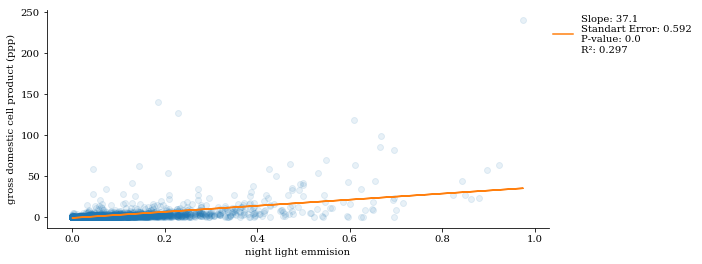

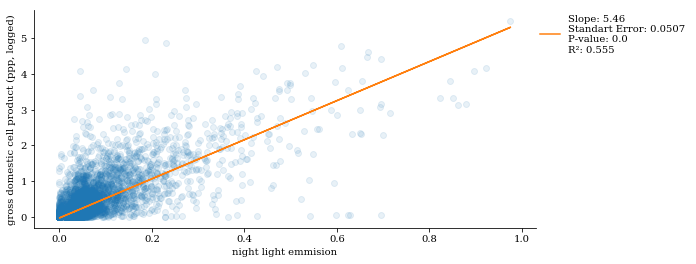

In [14]:
# show the corrolation between light and gcp:

def wealth_corr(df=df):

    data = df.dropna()

    # normal:
    
    plt.figure(figsize=[9,4])
    
    x = data['nlights_calib_mean']
    y = data['interp_gcp_ppp']

    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x+intercept

    label = 'Slope: {:.3}\nStandart Error: {:.3}\nP-value: {:.3}\nR²: {:.3}'.format(slope, std_err, p_value,r_value**2)
    
    plt.scatter(x,y, label = '', alpha = 0.1)
    plt.plot(x, line, label = label, color = 'C1')
        
    plt.xlabel('night light emmision')
    plt.ylabel('gross domestic cell product (ppp)')
        
    plt.legend(frameon = False, loc = 2, bbox_to_anchor=(1, 1),  borderaxespad=0.)
    sns.despine()
    
    fig_title = 'corr_light_gcp.pdf'
    plt.savefig(fig_title, bbox_inches="tight")
    
    plt.show()
    #print('Slope: {:.3}\nStandart Error: {:.3}\nP-value: {:.3}\nR²: {:.3}'.format(slope, std_err, p_value,r_value**2))
    
    # ---------------------
    # log gcp:
    
    plt.figure(figsize=[9,4])
    
    x = data['nlights_calib_mean']
    y = np.log(data['interp_gcp_ppp'] +1)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x+intercept
    
    label = 'Slope: {:.3}\nStandart Error: {:.3}\nP-value: {:.3}\nR²: {:.3}'.format(slope, std_err, p_value,r_value**2)
    
    plt.scatter(x,y, label = '', alpha = 0.1)
    plt.plot(x, line, label = label, color = 'C1')
        
    plt.xlabel('night light emmision')
    plt.ylabel('gross domestic cell product (ppp, logged)')
        
    plt.legend(frameon = False, loc = 2, bbox_to_anchor=(1, 1),  borderaxespad=0.)
    sns.despine()
    
    fig_title = 'corr_light_gcp_log.pdf'
    plt.savefig(fig_title, bbox_inches="tight")
    
    plt.show()
    #print('Slope: {:.3}\nStandart Error: {:.3}\nP-value: {:.3}\nR²: {:.3}'.format(slope, std_err, p_value,r_value**2))
    

df_s = df.sample(10000)# For faster plotting
wealth_corr(df_s)

## low and high ratio from Cederman, Gleditsch and Buhuag

In [15]:
# FOR light (WITH YEAR!!):

# Create vector of means
# Den strafffer lande med mange tyndt eller ubeboet celler...

df['mean_light'] = df.groupby(['gwno','year'])['nlights_calib_mean'].transform(np.mean) # this shit! Måske netop np.where herfra..

# Create vector base low_ratio (for now called low...)
df['low_ratio_light'] = (df[df['nlights_calib_mean'] < df['mean_light']]['mean_light']+1) / (df[df['nlights_calib_mean'] < df['mean_light']]['nlights_calib_mean']+1) # +1 tt avoid /0
df.loc[df['nlights_calib_mean'] >= df['mean_light'],'low_ratio_light'] = 1

# Create vector base high_ratio (for now called high...)
df['high_ratio_light'] = df[df['nlights_calib_mean'] > df['mean_light']]['nlights_calib_mean'] / df[df['nlights_calib_mean'] > df['mean_light']]['mean_light']
df.loc[df['nlights_calib_mean'] <= df['mean_light'],'high_ratio_light'] = 1

## Simpler median deprevation features:

In [16]:
# LIGHT:---------------------------------------------------
# Den strafffer lande med mange tyndt eller ubeboet celler...

df['country_year_median_light'] = df.groupby(['gwno','year'])['nlights_calib_mean'].transform(np.median) # this shit! Måske netop np.where herfra..

df['diff_median_light'] = df['country_year_median_light'] - df['nlights_calib_mean'] # 

# df['diff_median_light_zero'] = df['diff_median_light']

# df.loc[df['diff_median_light_zero'] <=0, 'diff_median_light_zero'] = 0


## Excluded from Cederman, Gleditsch and Buhuag

In [17]:
# binary excluded vriabel. Asking 'if', not 'how many'.
df['excluded_binary'] = pd.Series(df['excluded'] > 0).astype('int')

## "light per capita" for both conutry and cell:

In [18]:
# Den du laver for ligth pr. capitca Er sådan noget ihs

# Country specific
df['sum_nlight'] = df.groupby(['gwno','year'])['nlights_calib_mean'].transform(np.sum)
df['country_pop_sum'] = df.groupby(['gwno','year'])['interp_pop_gpw_sum'].transform(np.sum)

df['light_capita_country'] = df['sum_nlight']/df['country_pop_sum'] 

# to get more comparable values
df['light_capita_country_std'] = (df['light_capita_country'] - df['light_capita_country'].mean())/df['light_capita_country'].std()

# Cell speficic
df['light_capita_cell'] = df['nlights_calib_mean']/(df['interp_pop_gpw_sum']+1) #isf
df['light_capita_cell_std'] = (df['light_capita_cell'] - df['light_capita_cell'].mean())/df['light_capita_cell'].std()




### Make a few interactions: 
not used in final effort..

### Country pop and size

In [19]:
# Virker fint

df['country_area_sum'] = df.groupby(['gwno','year'])['landarea'].transform(np.sum) # this shit! Måske netop np.where herfra..
#df['country_pop_sum'] = df.groupby(['gwno','year'])['interp_pop_gpw_sum'].transform(np.sum) # this shit! Måske netop np.where herfra.. # den har du nu lave tidligere.



In [20]:
df[(df['gwno'] == 2 ) & (df['year'] == 2010)][['country_area_sum','country_pop_sum']].head() # passer på usa wiki areal og folke tælling 2010. ca.

,country_area_sum,country_pop_sum
65584,9.428286e+06,3.086483e+08
65605,9.428286e+06,3.086483e+08
65626,9.428286e+06,3.086483e+08
65647,9.428286e+06,3.086483e+08
65668,9.428286e+06,3.086483e+08


# pop dens country and cell:

In [21]:
# mass divided by volumen

df['pop_cell_dens'] = df['interp_pop_gpw_sum']/(df['landarea'])
df['pop_country_dens'] = df['country_pop_sum']/(df['country_area_sum']+1)

# interaction with excluded:

# df['pop_cell_dens_excluded'] = df['pop_cell_dens'] * df['excluded']

# df['pop_cell_dens_excluded_b'] = df['pop_cell_dens'] * df['excluded_binary']

# det med + 1 går nok ikke men det ser ellers fint ud...
# men der burde heller ikke være nogen med 0? og hvis der er gør +1 minimal forskel...

### Logs:


In [22]:
# New

def log_transformation(df = df):
    
#     features_not_to_log = ['gid','geometry','year','gwno',
#                            'excluded','petroleum_full','log_best','best']  # lead_binary_best
    # log_best already definded.. Men hvorfor har du gjort det?
    
    features_to_log = ['ttime_mean',
                       'interp_pop_gpw_sum',
                       'interp_urban_ih',
                       'interp_agri_ih',
                       'interp_forest_ih',
                       'bdist1',
                       'bdist3',
                       'capdist',
                       'past_fatalities',
                       'fatilities_country_year',
                       'interp_pop_gpw_country_sum',
                       'light_capita_country_std',
                       'light_capita_cell_std',
                       'country_pop_sum',
                       'country_area_sum',
                       'pop_cell_dens',
                       'pop_country_dens',
                       'nearest_conflict']
    
    
    for feature in df.columns:
        
        if feature in features_to_log:
    
            feature_name = 'log_' + feature
    
            df[feature_name] = np.log(df[feature] + 1)

log_transformation()

In [23]:
df.shape

(1361166, 61)

In [24]:
# Lead log best
df['lead_log_best'] = df.sort_values('year').groupby(['gid'])['log_best'].shift(-1)

In [25]:
# drop country coinflict year.

In [26]:
import pickle 
    
file_name = "full_df.pkl"
output = open(file_name, 'wb') # still not working right!!
pickle.dump(df, output)
output.close()

In [27]:

pkl_file = open('full_df.pkl', 'rb')

pickle_test_gdf = pickle.load(pkl_file)

pkl_file.close()

In [28]:
pickle_test_gdf.shape

(1361166, 62)

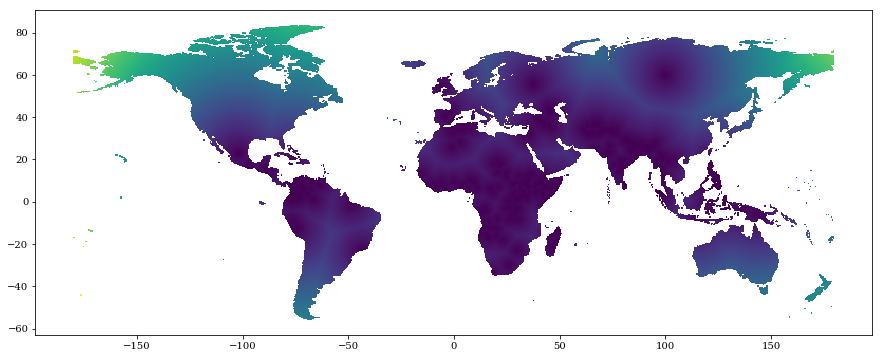

In [29]:
pickle_test_gdf[pickle_test_gdf['year']==2002].plot(column = 'nearest_conflict', figsize=(15, 15))
plt.show()